In [1]:
import pandas as pd # standard
import numpy as np # standard
from sklearn import tree # package to make decision tree
from sklearn.metrics import accuracy_score # for accuracy calculation
from sklearn.model_selection import StratifiedKFold # stratified k fold indices

import matplotlib.pyplot as plt
import seaborn as sns


import thermogram_utilities

#from sklearn.tree import export_graphviz
#import graphviz

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")

# replace NA with control
df['CancerType'] = np.where(df['CancerType'].isna(), 'Control', df['CancerType'])

# keep only Control and Adenocarcinoma for analysis
df_tree = df[(df['CancerType'] == 'Control') | (df['CancerType'] == 'Adenocarcinoma')]

In [3]:
df_long = pd.melt(df_tree, id_vars=['sample_id', 'pub_id', 'CancerType'], var_name='temp', value_name='dsp' )

median_df = thermogram_utilities.median_curve(df_long, 'CancerType', 'temp', 'dsp')

median_df['temperature'] = median_df['temperature'].str.replace('T', '').astype(float)

Text(0.5, 1.0, 'Median Lung Cancer Thermograms')

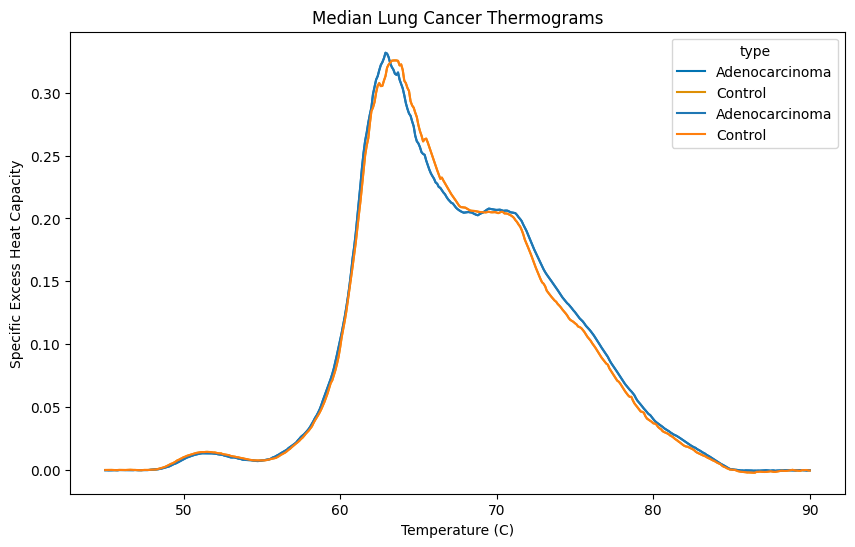

In [4]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(data=median_df, x='temperature', y='median', hue='type', palette='colorblind')
ax = plt.gca()

# Plot the lines with different colors for 'type'
sns.lineplot(data=median_df, x='temperature', y='median', hue='type')

# Add ribbons for each 'type' with different colors
'''for _, row in median_df.iterrows():
    ax.fill_between([row['temperature']], row['lower_q'], row['upper_q'], alpha=0.3, color='grey')'''

plt.xlabel('Temperature (C)')
plt.ylabel('Specific Excess Heat Capacity')
plt.title('Median Lung Cancer Thermograms')

In [5]:
# create empty df to store cv results and feature importance
performance_metrics = pd.DataFrame(columns=['Train', 'Test', 'Train Accuracy', 'Test Accuracy'])

temps = df_tree.drop(['CancerType', 'sample_id', 'pub_id'], axis = 1).columns.str.replace('T', '')
temps = temps.astype(float)
feature_importance = pd.DataFrame({"Temperature":temps})

new_columns = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

# define the number of splits and random seed for StratifiedKFold
n_splits = 5
random_seed = 42
skf = StratifiedKFold(n_splits=n_splits, random_state=random_seed, shuffle=True)

# initialize lists to store train and test indices
train_indices_list = []
test_indices_list = []

# loop through the splits and extract train and test indices
for train_indices, test_indices in skf.split(df_tree, df_tree['CancerType']):

    # append train and test indices to their lists
    train_indices_list.append(train_indices)
    test_indices_list.append(test_indices)

# access the rows of the thermogram df using the indices
for fold in range(n_splits):

    # get training and testing dataframes
    train_df = df_tree.iloc[train_indices_list[fold]].drop(['sample_id', 'pub_id'], axis = 1)
    test_df = df_tree.iloc[test_indices_list[fold]].drop(['sample_id', 'pub_id'], axis = 1)
    
    # train the decision tree using the train set
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit( train_df.drop('CancerType', axis = 1), train_df['CancerType'])

    # predict the train set / test set
    train_predictions = clf.predict(train_df.drop('CancerType', axis = 1))
    test_predictions = clf.predict(test_df.drop('CancerType', axis = 1))

    # compare predictions to labels
    test_accuracy = accuracy_score(test_predictions, test_df['CancerType'])
    train_accuracy = accuracy_score(train_predictions, train_df['CancerType'])

    # store train/test indices and accuracy
    performance_metrics.loc[len(performance_metrics)] = [train_indices_list[fold], test_indices_list[fold], train_accuracy, test_accuracy]

    column_name = new_columns[fold]
    column_values = clf.feature_importances_

    feature_importance[column_name] = column_values

    #feature_importance.loc[len(feature_importance)] = [fold, temps, feature_importance_vals]
    #feature_importance = pd.concat([temps, feature_importance_vals], axis=0, ignore_index=True)
    
print(skf)


StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


Text(0.5, 1.0, 'Temperature and Importance')

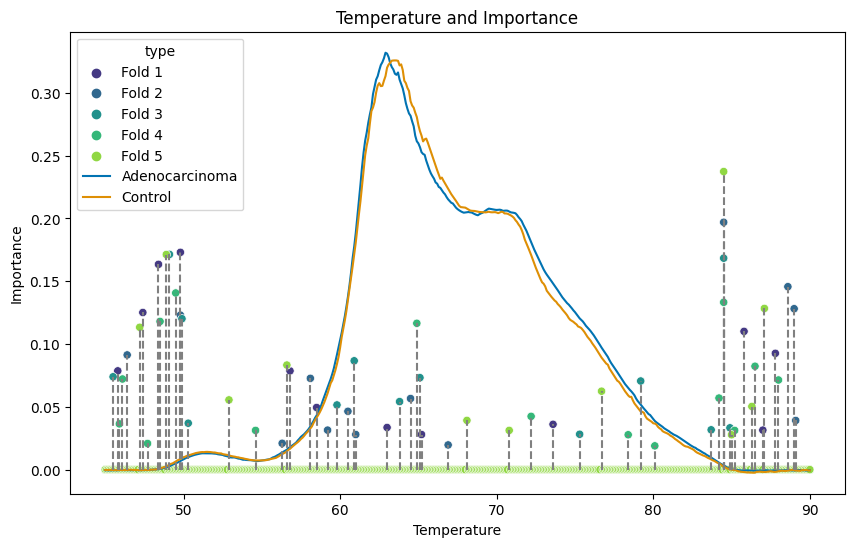

In [6]:
# pivot variable importance df to long
feature_importance_long = pd.melt(feature_importance, id_vars=['Temperature'], var_name='Fold', value_name='Importance' )
plt.figure(figsize=(10, 6))

# create a bar plot
sns.scatterplot(data=feature_importance_long, x='Temperature', y='Importance', hue='Fold', palette='viridis')
p = sns.lineplot(data=median_df, x='temperature', y='median', hue='type', palette='colorblind')

for index, row in feature_importance_long.iterrows():
    x_value = row['Temperature']
    y_value = row['Importance']
    
    # Add a vertical line from the point to the x-axis
    plt.plot([x_value, x_value], [0, y_value], color='gray', linestyle='--')


# add labels and title
plt.xlabel('Temperature')
plt.ylabel('Importance')
plt.title('Temperature and Importance')